# ARIMA'yı Ayrıştırma ile Birleştirmek

Basit bir ARIMA modeli sürecini zaten ele almıştık. Bu alıştırmada, derste gördüğünüz `seasonal decompose` aracıyla bir ARIMA modelinin kombinasyonunu kullanarak bu konuyu biraz daha geliştireceğiz. Mevsimsellikle __özel olarak__ başa çıkmak için kullanabileceğimiz modeller var, ancak burada adım adım ilerleyerek bu zaman serisini manuel olarak parçalayacağız, böylece onu tam olarak anlayacağız ve TS verileriyle çalışırken karşılaşabileceğimiz sorunları öğreneceğiz.

Bu challenge için günlük CO2 ppm ölçümleriyle çalışacağız, özellikle Mauna Loa Gözlemevi'nden alınan günlük CO2 ölçümleriyle 🌋

Bu ölçümler 1958'den beri alınıyor ve iklim biliminin temel taşlarından biri. Hawaii'de 3.000 metreden fazla yükseklikte konumlanmış olan gözlemevi, yerel emisyonlardan büyük ölçüde uzak olarak küresel atmosferik karbon seviyelerini izlemek için ideal bir konumdadır. Kayıtlar sağlam olmasına rağmen, __ara sıra enstrüman sorunları veya aşırı hava koşulları nedeniyle boşluklar içermektedir__, araştırmacılar bu kritik veri setinin bütünlüğünü korumak için analizlerinde bunları hesaba katmalıdır. 1974'ten beri __neredeyse__ günlük olarak alınan verilerin bir kısmını kullanacağız - notebook boyunca verilerdeki boşlukları ele alacağız!

Laboratuvarın yaptığı iklim çalışmaları hakkında merak ediyorsanız, buradan daha fazla bilgi edinebilirsiniz: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Veriyi Yükleme ve Keşfetme

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/co2_daily_mlo.csv")

In [3]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


Verilerin çalışmamız için pek güzel formatlanmadığını görebiliyoruz, bu yüzden önce `pd.to_datetime()` kullanarak bu adımı çözelim (bu fonksiyonu aynı anda birden fazla sütunda kullanabilirsiniz 👀). Daha fazla bilgi için [dokümanları](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) kontrol edin.

Doğru şekilde formatladıktan sonra, bunu index olarak ayarlayın.

In [4]:
# Tarih kolonlarını datetime'a çevir ve index yap

# (Dataset genelde year, month, day içeriyor. Yoksa Date kolonu üzerinden gider.)
if set(["year", "month", "day"]).issubset(df.columns):
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])
elif "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
elif "Date" in df.columns:
    df["date"] = pd.to_datetime(df["Date"])
else:
    raise ValueError("Tarih kolonlarını bulamadım. df.columns'a bakıp tarih kolonunu belirtmelisin.")

df = df.set_index("date").sort_index()
df.head()

,year,month,day,CO2 molfrac (ppm)
date,,,,
1974-05-17,1974,5,17,333.38
1974-05-18,1974,5,18,333.11
1974-05-19,1974,5,19,333.46
1974-05-20,1974,5,20,333.64
1974-05-21,1974,5,21,333.50


CO2 değerlerinizi çizdirin ve partnerinizle ne gördüğünüzü tartışın. Verilerinizde herhangi bir boşluk var gibi görünüyor mu? __Emin misiniz__? DataFrame'inizin ilk 50 değerini kontrol edin

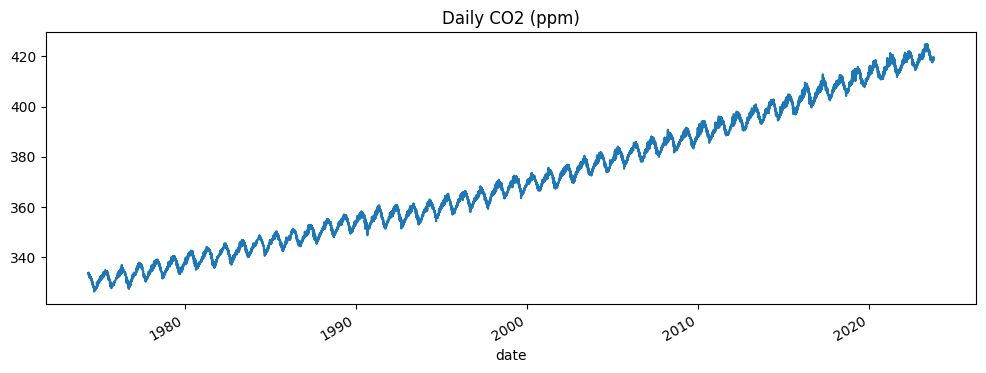

In [5]:
df["CO2 molfrac (ppm)"].plot(figsize=(12,4))
plt.title("Daily CO2 (ppm)")
plt.show()

In [6]:
df.head(50)

,year,month,day,CO2 molfrac (ppm)
date,,,,
1974-05-17,1974,5,17,333.38
1974-05-18,1974,5,18,333.11
1974-05-19,1974,5,19,333.46
1974-05-20,1974,5,20,333.64
1974-05-21,1974,5,21,333.50
1974-05-22,1974,5,22,333.21
1974-05-23,1974,5,23,333.05
1974-05-26,1974,5,26,333.32
1974-05-27,1974,5,27,332.79


Bazı tarihleri kaybetmişiz 😱 Açık `NaN` değerlerimiz olmasa da, index'imizde eksik tarihler var. Bu, TS verileriyle çalışırken __gerçekten__ dikkatli olmanız gereken bir şey.

Kaç gün eksik olduğumuzu hesaplayalım. Bitiş tarihinizi (`index`'inizin `max()`'ı) başlangıç tarihinizden (`index`'inizin `min()`'ı) çıkararak ikisi arasında kaç gün __olması gerektiğini__ görelim.

In [7]:
expected_days = (df.index.max() - df.index.min()).days + 1
expected_days

18058

Bu, DataFrame'imizde __gerçekten__ sahip olduğumuz gün sayısından nasıl farklı? Cevabınızı `missing` değişkenine kaydedin

In [8]:
# Kaç gün OLMASI gerekiyordu?
expected_days = (df.index.max() - df.index.min()).days

# Gerçekte kaç gün VAR?
actual_days = df.shape[0]

# Kaç gün EKSİK?
missing = expected_days - actual_days

missing

2861

In [9]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing PASSED                        [100%]

============================== 1 passed in 0.00s ===============================


💯 You can commit your code:

git add tests/missing.pickle

git commit -m 'Completed missing step'

git push origin master



Eksik değerlerin gerçekte nerede olduğunu görelim. Sahip __olmamız gereken__ index'i oluşturmak için `pd.date_range` kullanın. Ardından DataFrame'in `.reindex()` fonksiyonunu bu yeni tarih aralığıyla kullanarak ilk 100 girişimizde null değerlerin gerçekte nerede olduğunu görün!

In [10]:
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
df_reindexed = df.reindex(full_index)

df_reindexed.head(100)

,year,month,day,CO2 molfrac (ppm)
1974-05-17,1974.0,5.0,17.0,333.38
1974-05-18,1974.0,5.0,18.0,333.11
1974-05-19,1974.0,5.0,19.0,333.46
1974-05-20,1974.0,5.0,20.0,333.64
1974-05-21,1974.0,5.0,21.0,333.50
...,...,...,...,...
1974-08-20,1974.0,8.0,20.0,329.07
1974-08-21,1974.0,8.0,21.0,329.41
1974-08-22,NaN,NaN,NaN,NaN
1974-08-23,1974.0,8.0,23.0,328.76


Buradaki en basit seçenek, çok kullanışlı olan `pd.interpolate("linear")` fonksiyonunu kullanarak bunları bizim için doldurmak. Ne yaptığını görmek için aşağıdaki hücreyi çalıştırmayı deneyin:

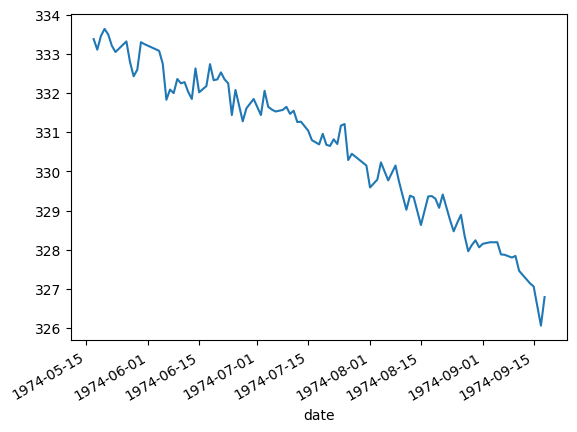

In [11]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot();

Interpolation bizim için noktaları bağlamak için basit bir doğrusal yöntem kullanır 😊 Tabii ki bu mükemmel olmayan bazı varsayımlar yapıyor ve aslında günlük örneklere ihtiyacımız yok - bunun yerine DataFrame'imizi aylık bazda `resample` edeceğiz ve bunu modellemeye çalışacağız. Her ayın ortalamasını içeren bir DataFrame oluşturmak için `.resample()` fonksiyonunu kullanmayı deneyin ve bunu `monthly` olarak adlandırın. [Dokümanları](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) burada görün.

In [12]:
monthly = (
    df_reindexed["CO2 molfrac (ppm)"]
    .interpolate("linear")
    .resample("ME")   # ✅ 'M' deprecated → 'ME'
    .mean()
    .to_frame()
)

monthly.head()

,CO2 molfrac (ppm)
1974-05-31,333.160667
1974-06-30,332.238833
1974-07-31,331.052742
1974-08-31,329.154032
1974-09-30,327.321167


Eğer __hala__ kalan null değerleriniz varsa, bunları doldurmak için `interpolate` kullanabilirsiniz. Yeniden örneklenmiş verilerinizi çizdirin:

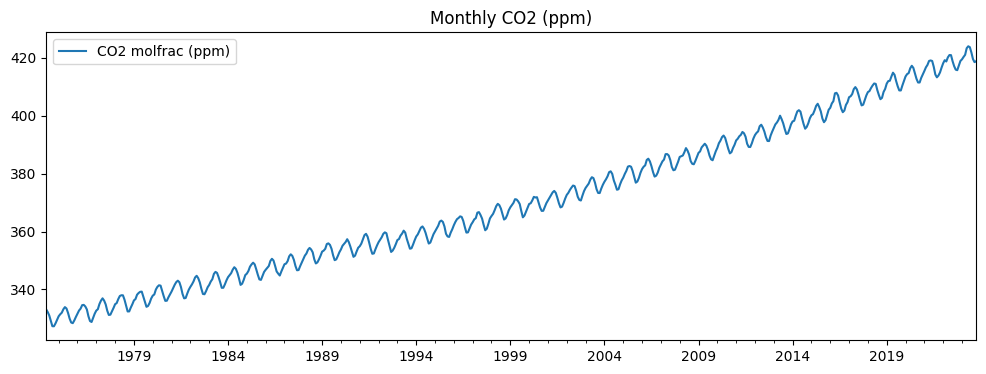

In [13]:
monthly.plot(figsize=(12,4))
plt.title("Monthly CO2 (ppm)")
plt.show()

<Axes: >

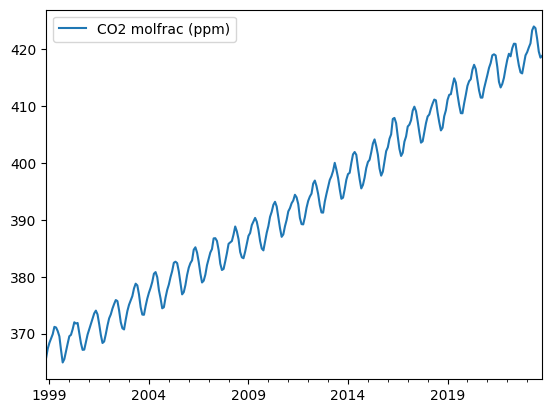

In [14]:
monthly[-300:].plot()

In [15]:
monthly["CO2 molfrac (ppm)"].iloc[0]

333.16066666666666

In [16]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

============================== 2 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/monthly.pickle

git commit -m 'Completed monthly step'

git push origin master



## Eğitim Test Ayrımı

Şimdi eğitim ve test kümelerine ayırmamız gerekiyor (%80:%20 ayrımı yapacağız). Bunu yaparken dikkatli olun - kümelerimizin __sürekli__ olması gerekiyor!

In [17]:
split_idx = int(len(monthly) * 0.8)

train = monthly.iloc[:split_idx].copy()
test  = monthly.iloc[split_idx:].copy()

Veri hazırlığımız neredeyse bitti. Ancak ayrıştırma ve modellemeye başlamadan önce, modelimizin nasıl performans gösterdiğini görmek için bir baseline oluşturmalıyız.

Seçeceğimiz tipik baseline, bize mevcut olan son değeri tahmin etmektir. Bizim durumumuzda, bu sadece `train` DataFrame'imizdeki son noktadır.

`test` DataFrame'inizde `naive_preds` adında bir sütun oluşturun ve bunu `train`'deki son mevcut veri noktamıza eşit olarak ayarlayın


In [18]:
last_train_value = train.iloc[-1, 0]
test["naive_preds"] = last_train_value

Bunu yaptıktan sonra, iki sütun arasındaki ortalama mutlak hatayı hesaplayın ve bunu `baseline_mae` olarak ayarlayın.

In [19]:
baseline_mae = np.mean(
    np.abs(test["CO2 molfrac (ppm)"] - test["naive_preds"])
)

baseline_mae

14.501157271050824

In [20]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

=============================== warnings summary ===============================
test_baseline.py::TestBaseline::test_first_value
  /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests/test_baseline.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

## Modellemeye Hazırlanmak

Bazı Zaman Serisi modelleriyle, verilerimizi modele atabilir ve onun bizim için ayrıştırmasını, durağan hale getirmesini ve sonra modellemesini umabiliriz (SARIMAX veya TBATS bunun iyi örnekleridir), ancak bunun yerine adım adım ilerleyeceğiz. Mevsimsellik ve trendi bizim için kaldıracak bir modele güvenmediğimiz için, bunları kendimiz halledeceğiz.

Derste gördüğünüz `seasonal_decompose` aracını import edin ve Zaman Serinizde her iki yöntemi de deneyin (hem "multiplicative" hem "additive").

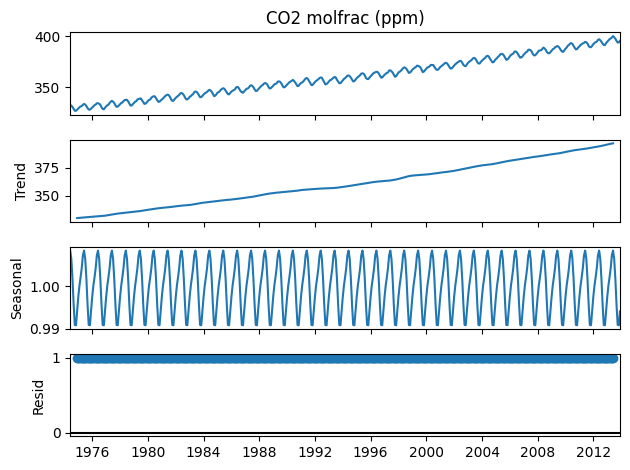

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative = seasonal_decompose(
    train["CO2 molfrac (ppm)"],
    model="multiplicative",
    period=12
)

multiplicative.plot();

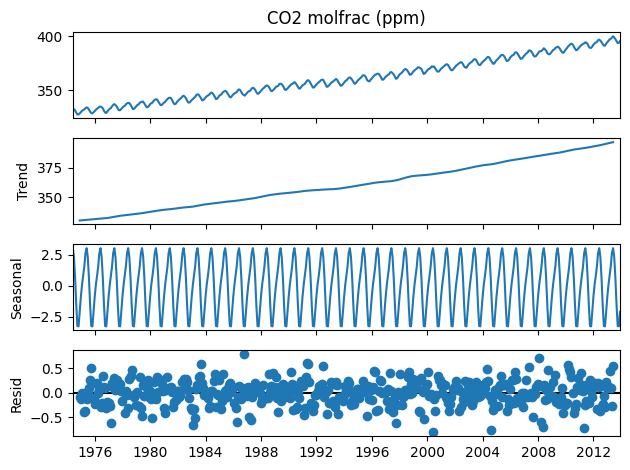

In [22]:
additive = seasonal_decompose(
    train["CO2 molfrac (ppm)"],
    model="additive",
    period=12
)

additive.plot();

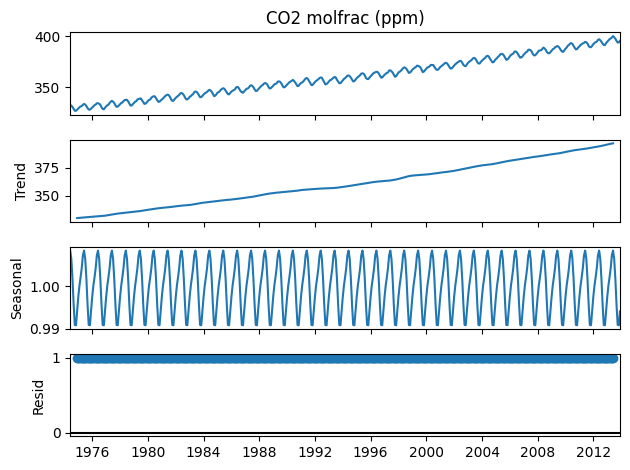

In [23]:
multiplicative = seasonal_decompose(
    train["CO2 molfrac (ppm)"],
    model="multiplicative",
    period=12
)

multiplicative.plot();

Her ikisinden de residualleri (`.resid` attribute'una erişin) çizdirin ve unutmayın - zamandan mümkün olduğunce __etkilenmemiş__ görünen olanı istiyoruz

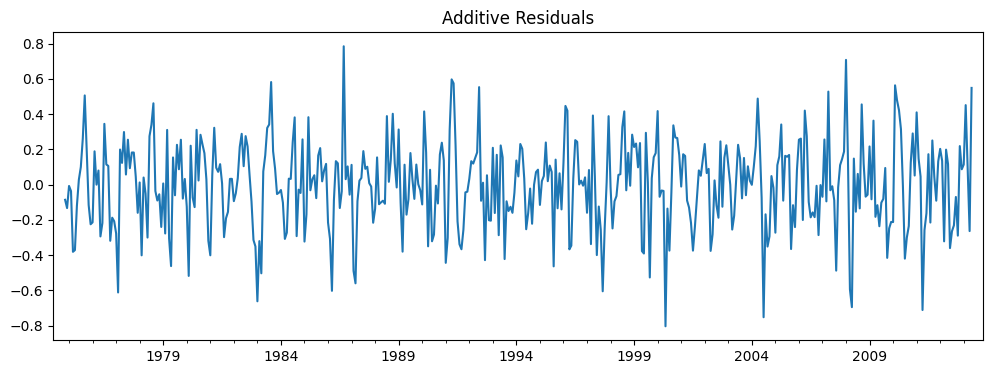

In [24]:
additive.resid.plot(figsize=(12,4), title="Additive Residuals")
plt.show()

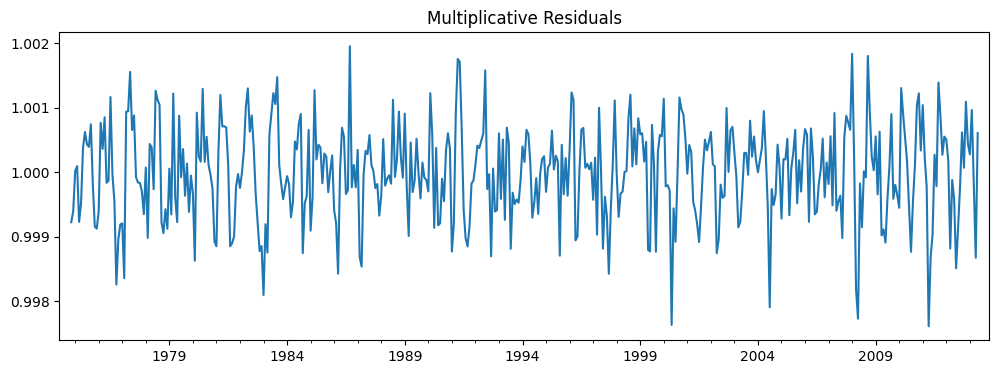

In [25]:
multiplicative.resid.plot(figsize=(12,4), title="Multiplicative Residuals")
plt.show()

Her ikisi de makul ölçüde durağan göründüğü için, multiplicative modeli seçeceğiz.

Şimdi stratejimiz zaman serimizin mevsimsel bileşenini çıkarmak.

Bunu nasıl yapabiliriz? 🤔


İlk olarak, `train` DataFrame'inizde zaman serinizin `.seasonal` bileşeniyle doldurulmuş `"seasonal_component"` adında bir sütun oluşturun.

Bunu yaptıktan sonra, sadece mevsimsel bileşenlerinizin __bir yılını__ içeren (yani `seasonal components` sütununuzun ilk 12 satırı) ayrı, daha küçük bir DataFrame oluşturun. Bu daha sonra bizim için yararlı olacak. Bunu `seasonal_one_year` olarak adlandırın ve karşılık gelen `index.month`'a eşit bir `"month"` sütununuz olduğundan emin olun (örneğin, Ocak mevsimsel bileşenine sahip bir satırınız ve yanında 1 olsun).

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [26]:
train["seasonal_component"] = multiplicative.seasonal
train.head()

,CO2 molfrac (ppm),seasonal_component
1974-05-31,333.160667,1.008457
1974-06-30,332.238833,1.006537
1974-07-31,331.052742,1.001817
1974-08-31,329.154032,0.995704
1974-09-30,327.321167,0.990936


Bu multiplicative bir modelden geldiği için, bu mevsimsel bileşeni __kaldırmak__ istiyorsak, orijinal zaman serimizi bu tekrarlanan (12 aylık döngü) değerlere __bölmemiz__ gerekecek.

In [27]:
seasonal_one_year = (
    train[["seasonal_component"]]
    .iloc[:12]
    .copy()
)

seasonal_one_year["month"] = seasonal_one_year.index.month
seasonal_one_year

,seasonal_component,month
1974-05-31,1.008457,5
1974-06-30,1.006537,6
1974-07-31,1.001817,7
1974-08-31,0.995704,8
1974-09-30,0.990936,9
1974-10-31,0.990843,10
1974-11-30,0.994130,11
1974-12-31,0.997570,12
1975-01-31,1.000269,1
1975-02-28,1.002098,2


In [28]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



Orijinal zaman serinizin değerini mevsimsel bileşene bölen `"seasonal_stripped"` adında yeni bir sütun oluşturun.

In [29]:
train["seasonal_stripped"] = train["CO2 molfrac (ppm)"] / train["seasonal_component"]
train[["CO2 molfrac (ppm)", "seasonal_component", "seasonal_stripped"]].head()

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.160667,1.008457,330.366807
1974-06-30,332.238833,1.006537,330.081135
1974-07-31,331.052742,1.001817,330.452160
1974-08-31,329.154032,0.995704,330.574136
1974-09-30,327.321167,0.990936,330.315085


Bu yeni sütunu çizdirin:

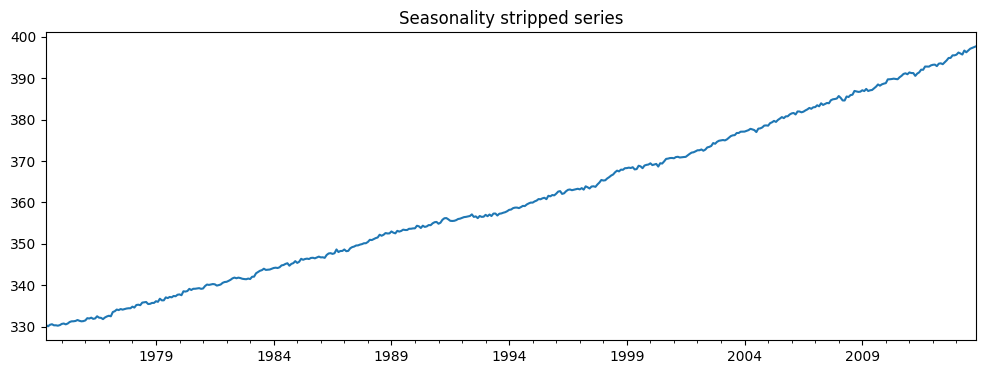

In [30]:
train["seasonal_stripped"].plot(figsize=(12,4), title="Seasonality stripped series");
plt.show()

Henuz durağan görünüyor mu? Günün arkadaşınızla neden öyle olduğunu veya olmadığını tartışın.

Bir sonraki görevimiz bu __mevsimsellikten arındırılmış__ zaman serisini alıp durağan hale getirmek. `.diff()` kullanmayı deneyin ve nasıl göründüğüne bakın. Sonra herhangi bir değişiklik görmek için bir kez daha diff yapmayı deneyin.

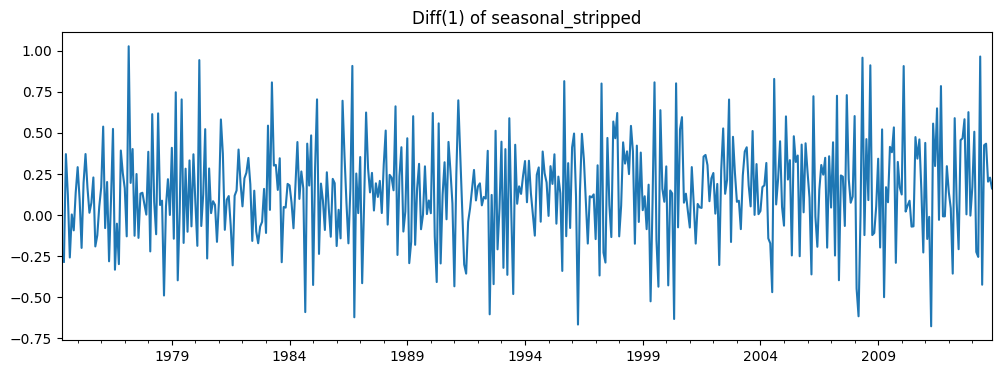

In [31]:
train["diff_1"] = train["seasonal_stripped"].diff()
train["diff_1"].plot(figsize=(12,4), title="Diff(1) of seasonal_stripped");
plt.show()

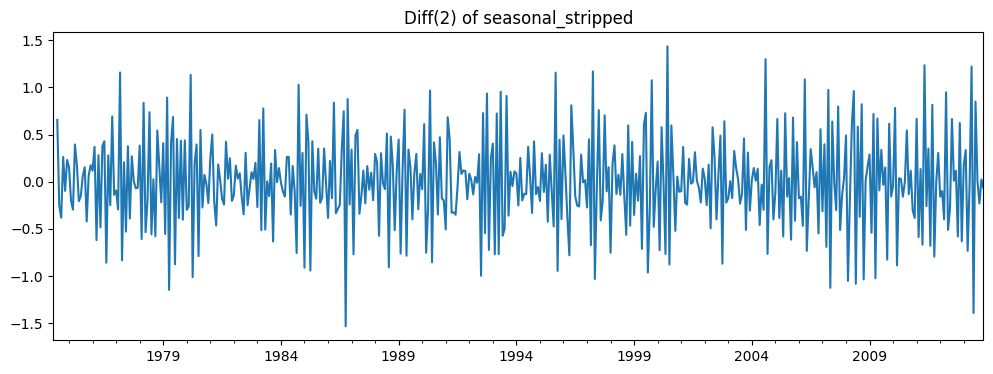

In [32]:
train["diff_2"] = train["diff_1"].diff()
train["diff_2"].plot(figsize=(12,4), title="Diff(2) of seasonal_stripped");
plt.show()

Her ikisi de görsel olarak oldukça durağan görünmeli, her birinin durağan olduğunu doğrulamak için derste gördüğünüz `adfuller` (Augmented Dicky-Fuller) testini kullanın.

Not: `diff` yaptığınızda DataFrame'inizde null değerler oluşturursunuz, ADF testi yapmak için bunları düşürmeniz gerekir.

In [33]:
from statsmodels.tsa.stattools import adfuller

adf_1 = adfuller(train["diff_1"].dropna())
print("ADF diff_1: test_stat=%.4f | p-value=%.6f" % (adf_1[0], adf_1[1]))

adf_2 = adfuller(train["diff_2"].dropna())
print("ADF diff_2: test_stat=%.4f | p-value=%.6f" % (adf_2[0], adf_2[1]))

ADF diff_1: test_stat=-19.0654 | p-value=0.000000
ADF diff_2: test_stat=-12.7280 | p-value=0.000000


Her ikisi de makul ölçüde durağan görünüyor ve aşırı differencing'e gerek yok gibi görünüyor (yine de daha sonra iki kez diff yapılmış bir zaman serisi oluşturmayı her zaman deneyebiliriz). Hadi `acf` ve `pacf` grafiklerimizi çizmeye devam edelim (herhangi bir `null` değeri düşürdüğünüzden emin olun - bunlar ACF ve PACF hesaplayıcılarınızı bozar) 😔

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

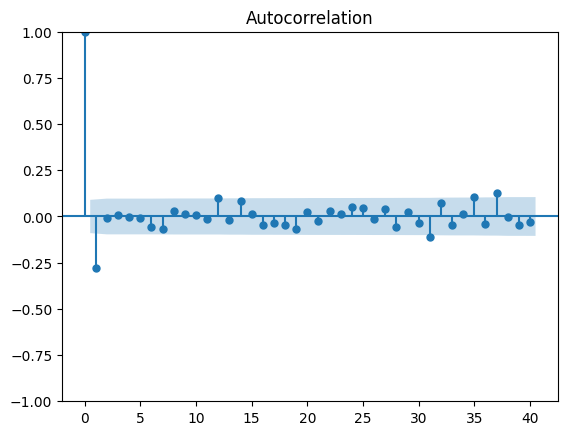

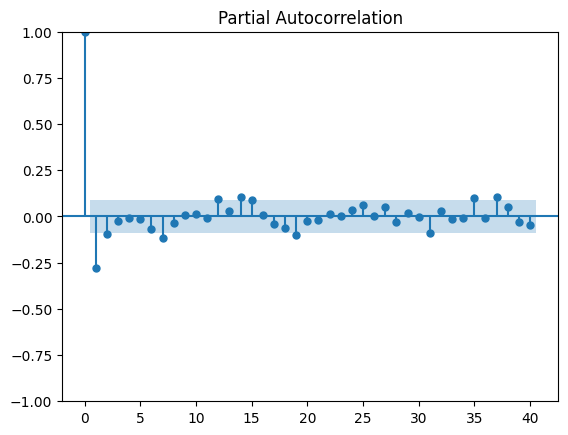

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

series_for_corr = train["diff_1"].dropna()

plot_acf(series_for_corr, lags=40);
plt.show()

plot_pacf(series_for_corr, lags=40, method="ywm");
plt.show()

Bu grafiklerin gerçekte ne anlama geldiğini arkadaşınızla konuşmak için zaman ayırın. Hangisi sizin `p` parametrenize karşılık geliyor ve hangisi `q` parametrenize?

Şimdi `p` `d` ve `q` değerleriniz için uygun order değerleriyle basit bir ARIMA modeli oluşturun. Model özetini inceleyin.

In [36]:
from statsmodels.tsa.arima.model import ARIMA

y = train["seasonal_stripped"].dropna()

model = ARIMA(y, order=(1, 1, 1))
arima_res = model.fit()

print(arima_res.summary())

                               SARIMAX Results                                
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -113.618
Date:                Wed, 21 Jan 2026   AIC                            233.237
Time:                        15:39:41   BIC                            245.720
Sample:                    05-31-1974   HQIC                           238.146
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   2785.829      0.000       0.999       1.001
ma.L1         -0.9950      0.011    -91.092      0.000      -1.016      -0.974
sigma2         0.0940      0.006     15.755      0.0

Özet hakkında ne fark ediyorsunuz? Buradaki en önemli özellikler neler?

Katsayılarımıza güvenebiliriz gibi görünüyor ve ~223'lük bir AIC'miz var. Ama bu en iyi model miydi? Farklı modelleri grid search yapmak ve hangisinin en iyi AIC'ye sahip olduğunu görmek için `auto_arima` fonksiyonunu kullanmayı deneyin

In [37]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped,diff_1,diff_2
1974-05-31,333.160667,1.008457,330.366807,NaN,NaN
1974-06-30,332.238833,1.006537,330.081135,-0.285672,NaN
1974-07-31,331.052742,1.001817,330.452160,0.371025,0.656697
1974-08-31,329.154032,0.995704,330.574136,0.121976,-0.249049
1974-09-30,327.321167,0.990936,330.315085,-0.259051,-0.381027
...,...,...,...,...,...
2013-07-31,397.388871,1.001817,396.667945,0.425299,0.850195
2013-08-31,395.396452,0.995704,397.102352,0.434407,0.009108
2013-09-30,393.704333,0.990936,397.305440,0.203088,-0.231319
2013-10-31,393.892742,0.990843,397.532954,0.227514,0.024426


En iyi AIC skorunuzu `best_AIC`'ye kaydedin

In [38]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
from pmdarima import auto_arima

auto_model = auto_arima(
    y,
    seasonal=False,
    start_p=0, start_q=0,
    max_p=6, max_q=6,
    d=1,              # diff_1 mantığı
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

best_AIC = auto_model.aic()
best_AIC

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=225.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.468, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=184.648, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=316.486, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=186.536, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=186.548, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=188.576, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=317.570, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.200 seconds


184.64785676749707

In [39]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score PASSED                          [100%]

============================== 1 passed in 0.06s ===============================


💯 You can commit your code:

git add tests/score.pickle

git commit -m 'Completed score step'

git push origin master



Çoğu zaman, hangi modelin verilerimize en iyi uyacağını tahmin etmek zor olabilir, bu yüzden genellikle grid-search yapmak ve modellerimizin AIC skorlarını karşılaştırmak iyi bir fikirdir 🧐 Burada, bir __(0,1,1)__ modelinin daha iyi bir AIC skoru aldığı görünüyor (yani orijinal modelimizin MA bileşenleri muhtemelen model likelihood'ımızı o kadar iyileştirmiyordu!)

### Tahminler Yapmak (biraz Pandas çalışmasına hazır olun!)

Artik en iyi modelimize sahip olduğumuza göre, bazı tahminler ve - önemlisi - bazı güven aralıkları oluşturmak istiyoruz. Test setinizin uzunluğu için tahmin yapmak üzere modelinizi kullanın ve bu aralıkları da döndürdüğünüzden emin olun (`return_conf_int = True` kullanın). `preds`, `upper` ve `lower` sınırları için sütunlar içeren bir `preds_df` DataFrame oluşturun.

In [40]:
import numpy as np
import pandas as pd

n_periods = len(test)

preds, conf_int = auto_model.predict(
    n_periods=n_periods,
    return_conf_int=True
)

In [41]:
preds_df = pd.DataFrame(
    {
        "preds": preds,
        "lower": conf_int[:, 0],
        "upper": conf_int[:, 1],
    },
    index=test.index
)

preds_df.head()

,preds,lower,upper
2013-12-31,397.817409,397.244880,398.389938
2014-01-31,397.959651,397.265220,398.654083
2014-02-28,398.101894,397.303971,398.899817
2014-03-31,398.244136,397.354683,399.133589
2014-04-30,398.386378,397.413973,399.358784


In [42]:
print(preds_df.shape)
print(preds_df.isna().sum())
preds_df.tail()

(119, 3)
preds    0
lower    0
upper    0
dtype: int64


,preds,lower,upper
2023-06-30,414.033037,409.798111,418.267964
2023-07-31,414.175280,409.922157,418.428402
2023-08-31,414.317522,410.046281,418.588762
2023-09-30,414.459764,410.170482,418.749046
2023-10-31,414.602007,410.294759,418.909255


In [43]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_preds.py::TestPreds::test_df_values PASSED                          [ 50%]
test_preds.py::TestPreds::test_preds_cols PASSED                         [100%]

============================== 2 passed in 0.27s ===============================


💯 You can commit your code:

git add tests/preds.pickle

git commit -m 'Completed preds step'

git push origin master



Şimdi bunları çizdirin ve `train` verilerinizle karşılaştırıldığında nasıl göründüklerine bakın

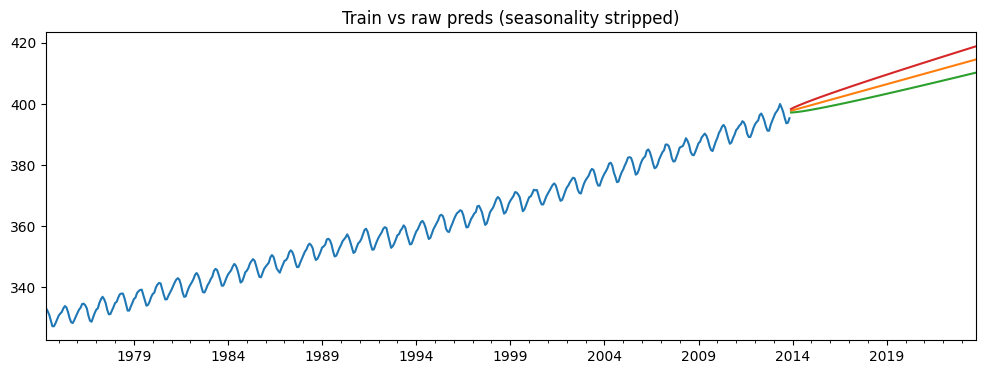

In [44]:
ax = train["CO2 molfrac (ppm)"].plot(figsize=(12,4), title="Train vs raw preds (seasonality stripped)")
preds_df["preds"].plot(ax=ax)
preds_df["lower"].plot(ax=ax)
preds_df["upper"].plot(ax=ax)
plt.show()

Bir şeyler biraz yanlış görünüyor, değil mi? Açıkça mevsimsellik olan bir şeyden çıkan üç düz çizgiye bakıyoruz. Bunu hesaba katmak için, daha önce çıkardığımız mevsimsellik bileşenini yeniden dahil etmemiz gerekiyor!

`preds_df` DataFrame'inizde bir `month` sütunu oluşturun ve bunu index'in ay bileşeniyle doldurun.

In [45]:
preds_df["month"] = preds_df.index.month
preds_df.head()

,preds,lower,upper,month
2013-12-31,397.817409,397.244880,398.389938,12
2014-01-31,397.959651,397.265220,398.654083,1
2014-02-28,398.101894,397.303971,398.899817,2
2014-03-31,398.244136,397.354683,399.133589,3
2014-04-30,398.386378,397.413973,399.358784,4


In [46]:
seasonal_one_year.head()

,seasonal_component,month
1974-05-31,1.008457,5
1974-06-30,1.006537,6
1974-07-31,1.001817,7
1974-08-31,0.995704,8
1974-09-30,0.990936,9


Artık daha önce oluşturduğumuz `seasonal_one_year` DataFrame'ini alıp `preds_df`'imize basitçe merge edebiliriz!

In [47]:
preds_df = preds_df.merge(
    seasonal_one_year[["month", "seasonal_component"]],
    on="month",
    how="left"
)

preds_df.head()

,preds,lower,upper,month,seasonal_component
0,397.817409,397.244880,398.389938,12,0.997570
1,397.959651,397.265220,398.654083,1,1.000269
2,398.101894,397.303971,398.899817,2,1.002098
3,398.244136,397.354683,399.133589,3,1.004327
4,398.386378,397.413973,399.358784,4,1.007312


In [48]:
preds_df

,preds,lower,upper,month,seasonal_component
0,397.817409,397.244880,398.389938,12,0.997570
1,397.959651,397.265220,398.654083,1,1.000269
2,398.101894,397.303971,398.899817,2,1.002098
3,398.244136,397.354683,399.133589,3,1.004327
4,398.386378,397.413973,399.358784,4,1.007312
...,...,...,...,...,...
114,414.033037,409.798111,418.267964,6,1.006537
115,414.175280,409.922157,418.428402,7,1.001817
116,414.317522,410.046281,418.588762,8,0.995704
117,414.459764,410.170482,418.749046,9,0.990936


Şimdi `preds_df` DataFrame'inde yeni sütunlar olarak `full_preds`, `upper_conf` ve `lower_conf`'ı (`preds`, `upper` __ve__ `lower` sütunlarınızı `preds_df` DataFrame'imizde artık sahip olduğumuz mevsimsel bileşenle çarparak) oluşturabilirsiniz.

In [49]:
preds_df["full_preds"] = preds_df["preds"] * preds_df["seasonal_component"]
preds_df["lower_conf"] = preds_df["lower"] * preds_df["seasonal_component"]
preds_df["upper_conf"] = preds_df["upper"] * preds_df["seasonal_component"]

preds_df[["preds","lower","upper","seasonal_component","full_preds","lower_conf","upper_conf"]].head()

,preds,lower,upper,seasonal_component,full_preds,lower_conf,upper_conf
0,397.817409,397.244880,398.389938,0.997570,396.850661,396.279523,397.421799
1,397.959651,397.265220,398.654083,1.000269,398.066561,397.371943,398.761179
2,398.101894,397.303971,398.899817,1.002098,398.937064,398.137467,399.736661
3,398.244136,397.354683,399.133589,1.004327,399.967176,399.073874,400.860477
4,398.386378,397.413973,399.358784,1.007312,401.299438,400.319922,402.278954


Son olarak, plotting'i bizim için kolaylaştırmak için, `preds_df`'nizin index'ini `test` DataFrame'inizin index'iyle aynı olacak şekilde ayarlayın (aynı uzunluğa sahip oldukları için bu bizim için oldukça kolay olmalı!)

In [50]:
preds_df.index = test.index
preds_df.head()

,preds,lower,upper,month,seasonal_component,full_preds,lower_conf,upper_conf
2013-12-31,397.817409,397.244880,398.389938,12,0.997570,396.850661,396.279523,397.421799
2014-01-31,397.959651,397.265220,398.654083,1,1.000269,398.066561,397.371943,398.761179
2014-02-28,398.101894,397.303971,398.899817,2,1.002098,398.937064,398.137467,399.736661
2014-03-31,398.244136,397.354683,399.133589,3,1.004327,399.967176,399.073874,400.860477
2014-04-30,398.386378,397.413973,399.358784,4,1.007312,401.299438,400.319922,402.278954


In [51]:
preds_df.index = test.index
preds_df.head()

,preds,lower,upper,month,seasonal_component,full_preds,lower_conf,upper_conf
2013-12-31,397.817409,397.244880,398.389938,12,0.997570,396.850661,396.279523,397.421799
2014-01-31,397.959651,397.265220,398.654083,1,1.000269,398.066561,397.371943,398.761179
2014-02-28,398.101894,397.303971,398.899817,2,1.002098,398.937064,398.137467,399.736661
2014-03-31,398.244136,397.354683,399.133589,3,1.004327,399.967176,399.073874,400.860477
2014-04-30,398.386378,397.413973,399.358784,4,1.007312,401.299438,400.319922,402.278954


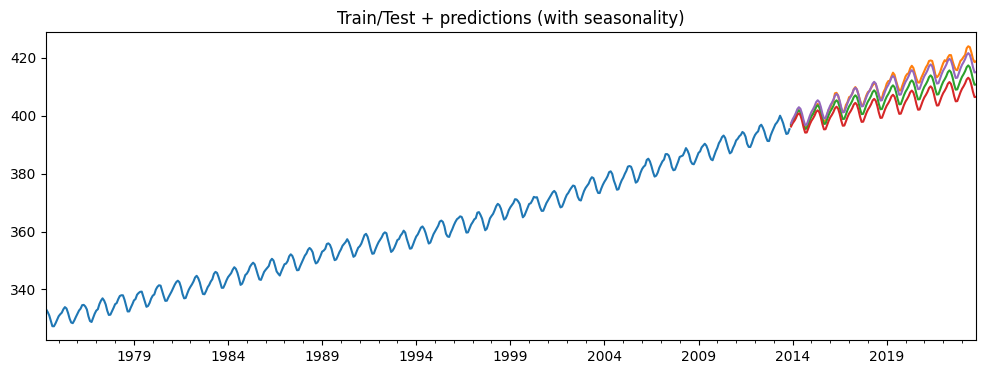

In [52]:
ax = train["CO2 molfrac (ppm)"].plot(figsize=(12,4), title="Train/Test + predictions (with seasonality)")
test["CO2 molfrac (ppm)"].plot(ax=ax)

preds_df["full_preds"].plot(ax=ax)
preds_df["lower_conf"].plot(ax=ax)
preds_df["upper_conf"].plot(ax=ax)

plt.show()

In [53]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_fullpreds.py::TestFullpreds::test_columns PASSED                    [ 50%]
test_fullpreds.py::TestFullpreds::test_index PASSED                      [100%]

============================== 2 passed in 0.27s ===============================


💯 You can commit your code:

git add tests/fullpreds.pickle

git commit -m 'Completed fullpreds step'

git push origin master



Şimdi her şeyi çizdirin - train'inizin sonu (örneğin son 100 değer), tam tahminleriniz, üst ve alt güven sınırları ve `preds_df` DataFrame'inizden gerçek değerler __ve__ baseline'nız!

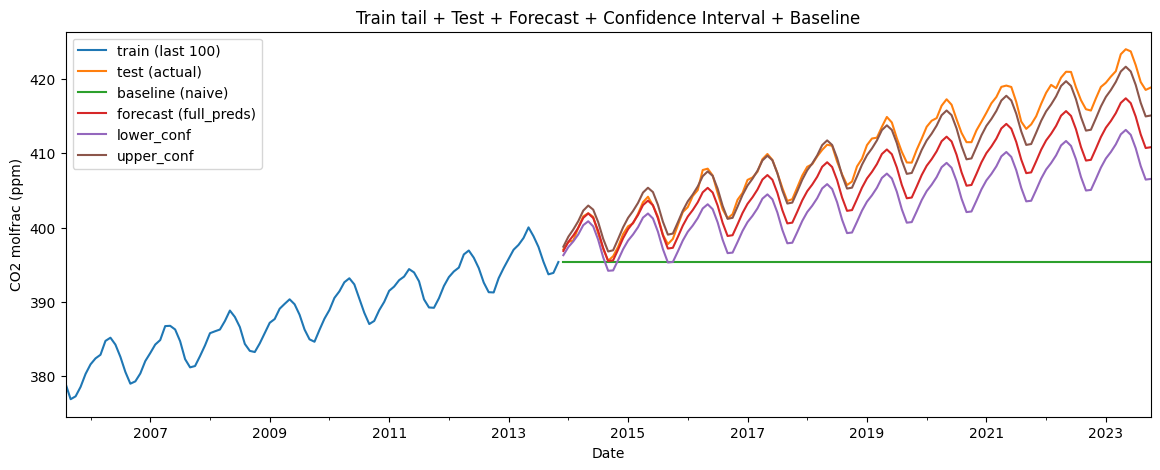

In [54]:
import matplotlib.pyplot as plt

# son 100 train
train_tail = train["CO2 molfrac (ppm)"].tail(100)

fig, ax = plt.subplots(figsize=(14,5))

# train son 100
train_tail.plot(ax=ax, label="train (last 100)")

# gerçek test
test["CO2 molfrac (ppm)"].plot(ax=ax, label="test (actual)")

# baseline (naive_preds) varsa
if "naive_preds" in test.columns:
    test["naive_preds"].plot(ax=ax, label="baseline (naive)")

# tahmin + güven aralığı (mevsimsellik geri eklenmiş full_preds)
preds_df["full_preds"].plot(ax=ax, label="forecast (full_preds)")
preds_df["lower_conf"].plot(ax=ax, label="lower_conf")
preds_df["upper_conf"].plot(ax=ax, label="upper_conf")

ax.set_title("Train tail + Test + Forecast + Confidence Interval + Baseline")
ax.set_xlabel("Date")
ax.set_ylabel("CO2 molfrac (ppm)")
ax.legend()
plt.show()

Tahminlerimiz oldukça iyi görünüyor! Gerçek değerlerin tahmin ettiklerimizden biraz daha yüksek olduğunu görebiliyoruz ancak tahmin yapmaya başladığımız zamandan tam 10 yıl sonrası için güven aralıklarımızın sınırları içinde iyi bir şekilde kalıyor.

Neden değerlerimiz gerçek değerlerin altına düştü? Test verisini ayrıştırmak ve trend bileşenine bakmak için aşağıdaki hücreyi çalıştırın 👀


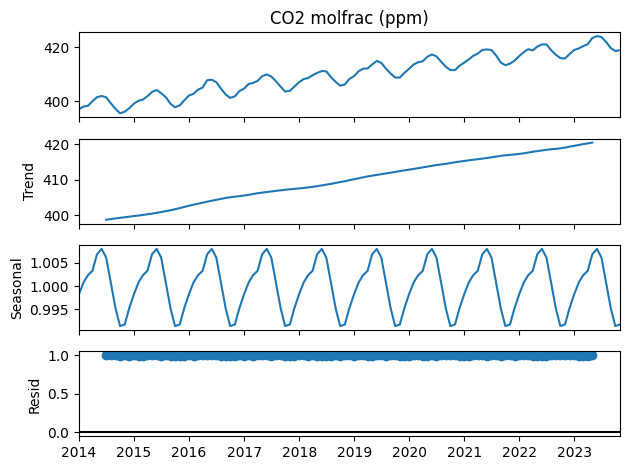

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(
    test["CO2 molfrac (ppm)"],
    model="multiplicative",
    period=12
).plot();

plt.show()

2016-2018'de normal (biraz daha sığ) trend tekrar devralınmadan önce tüm değerlerimizde __hafif bir artis__ olduğu görünüyor. Bu, test veri setimizde basitçe tahmin edemeyeceğimiz bir şeyin meydana gelmesinin harika bir örneği. CO2 okumalarında neden bir artış olduğunu bilmiyoruz - ve bunun için tahmin yapamadık.

❗ Zaman Serisi ile modelleme yaptığımızda, __sihirli bir şekilde geleceği tahmin edemeyiz__. Yapmaya çalıştığımız şey, geçmişin desenlerini doğru bir şekilde yakalamak ve sonra bunları genişletmektir.

- Çoğu zaman, ham tahminleriniz (mevsimsel bileşen olmadan) oldukça sıkıcı düz bir çizgi gibi görünecektir 🙄 (mevcut başlangıç tahminlerimizin yaptığı gibi) ancak bu beklediğimiz bir şey
- Zaman Serisi analizi yaparken elde ettiğimiz değerin çoğu, trendlerimizi, mevsimsel bileşenlerimizi ve güven aralıklarımızı __nicelleştirebilmemizde__ yatıyor, böylece iyi bilgilendirilmiş kararlar verebiliriz ✅

Son olarak, modelimizin baseline'ımızdan ne kadar daha iyi olduğunu hızlıca nicelleyelim. `preds`'leriniz (mevsimsel bileşenleriyle birlikte) ve gerçek değerler arasındaki ortalama mutlak hatayı hesaplayın. `model_mae`'nizin orijinal `baseline_mae`'den düşük olup olmadığına bakın.

In [56]:
import numpy as np

model_mae = np.mean(np.abs(test["CO2 molfrac (ppm)"] - preds_df["full_preds"]))
model_mae

3.653877013828689

In [57]:
print("baseline_mae:", baseline_mae)
print("model_mae:", model_mae)
print("improvement:", baseline_mae - model_mae)

baseline_mae: 14.501157271050824
model_mae: 3.653877013828689
improvement: 10.847280257222135


Final MAE'miz orijinal baseline'ımızdan __çok__ daha iyi olmalı. Harika iş 🥳 